# IEEE-CIS Fraud Detection Example Notebook


## Imports and helpers

In [1]:
import warnings
from pathlib import Path
import json

import matplotlib.pyplot as plt
import pandas as pd

from utils_data_io import (
    load_config,
    build_dataset,
    build_features,
    build_graph,
    train_tabular_baseline,
    train_lgbm_baseline,
    train_gnn_model,
)
from utils_post_processing import (
    compare_models_table,
    load_gnn_error_table,
    precision_recall_at_k,
)

warnings.filterwarnings('ignore')


/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


## Run settings (manual)
Set once, then run the notebook top-to-bottom.

In [2]:
# Toggle to reuse existing artifacts instead of rebuilding
USE_EXISTING_ARTIFACTS = True  

# Data/build controls
SAMPLE_FRAC = 0.30       # fraction of raw data to sample (0<frac<=1); None for full
MAX_ROWS = 590_000        # cap rows before sampling; None reads all (~590k rows)

# Split lengths
VAL_DAYS = 10             # validation window (days)
TEST_DAYS = 10            # test window (days)

# GraphSAGE training knobs
EPOCHS = 12                # increase if PR-AUC still climbing
HIDDEN_DIM = 192
NUM_LAYERS = 3
DROPOUT = 0.2
LR = 3e-4
THRESHOLD = 0.35
POS_WEIGHT_SCALE = 1.4    # >1 upweights fraud to favor recall/PR-AUC
DEVICE = 'auto'           # 'auto', 'cpu', or 'cuda'

print({k: globals()[k] for k in [
    'USE_EXISTING_ARTIFACTS','SAMPLE_FRAC','MAX_ROWS','VAL_DAYS','TEST_DAYS',
    'EPOCHS','HIDDEN_DIM','NUM_LAYERS','DROPOUT','LR','THRESHOLD','POS_WEIGHT_SCALE','DEVICE'
]})


{'USE_EXISTING_ARTIFACTS': True, 'SAMPLE_FRAC': 0.3, 'MAX_ROWS': 590000, 'VAL_DAYS': 10, 'TEST_DAYS': 10, 'EPOCHS': 12, 'HIDDEN_DIM': 192, 'NUM_LAYERS': 3, 'DROPOUT': 0.2, 'LR': 0.0003, 'THRESHOLD': 0.35, 'POS_WEIGHT_SCALE': 1.4, 'DEVICE': 'auto'}


## Inspect configuration

In [3]:
cfg = load_config()
cfg

{'project_root': '.',
 'data': {'raw_dir': 'data/raw',
  'processed_dir': 'data/processed',
  'artifacts_dir': 'data/artifacts',
  'merged_file': 'data/processed/merged.parquet',
  'sample_frac': 0.25,
  'random_state': 42},
 'splits': {'val_days': 10, 'test_days': 10},
 'graph': {'account_key': 'card1',
  'save_path': 'data/artifacts/hetero_graph.pt'},
 'tabular': {'target': 'isFraud',
  'features_out': 'data/processed/features.parquet',
  'report_dir': 'data/artifacts'}}

## Quick peek at raw merged data (optional)
Use this to sanity-check schema and class balance.

In [4]:
merged_path = Path(cfg['data']['merged_file'])
if merged_path.exists():
    df = pd.read_parquet(merged_path)
else:
    raw_tx = Path(cfg['data']['raw_dir']) / 'train_transaction.csv'
    df = pd.read_csv(raw_tx, nrows=50_000)
print(df.shape)
print(df[['TransactionDT','TransactionAmt','isFraud']].head())
print(df['isFraud'].value_counts(normalize=True).head())


(40000, 434)
   TransactionDT  TransactionAmt  isFraud
0          86400            68.5        0
1          86401            29.0        0
2          86469            59.0        0
3          86499            50.0        0
4          86506            50.0        0
isFraud
0    0.971775
1    0.028225
Name: proportion, dtype: float64


## Build data, features, and heterograph

In [5]:
artifact_paths = {
    'merged': Path(cfg['data']['merged_file']),
    'features': Path(cfg['tabular']['features_out']),
    'graph': Path(cfg['graph']['save_path']),
}

if USE_EXISTING_ARTIFACTS and all(p.exists() for p in artifact_paths.values()):
    print('Reusing existing artifacts:', artifact_paths)
else:
    merged = build_dataset(sample_frac=SAMPLE_FRAC, max_rows=MAX_ROWS)
    feats = build_features()
    graph = build_graph()
    print({'merged': merged, 'features': feats, 'graph': graph})


Reusing existing artifacts: {'merged': PosixPath('data/processed/merged.parquet'), 'features': PosixPath('data/processed/features.parquet'), 'graph': PosixPath('data/artifacts/hetero_graph.pt')}


## Train baselines (logreg + LightGBM)
LightGBM may skip on tiny samples; both auto-tune threshold on validation.

In [6]:
baseline_log = train_tabular_baseline(val_days=VAL_DAYS, test_days=TEST_DAYS)
try:
    baseline_lgbm = train_lgbm_baseline(val_days=VAL_DAYS, test_days=TEST_DAYS)
except RuntimeError as exc:
    print('LightGBM baseline skipped:', exc)
except ValueError as exc:
    print('LightGBM baseline skipped (tiny sample):', exc)


[run_baseline] Using fallback 60/20/20 time split for small sample.
{
  "model": "LogisticRegression(balanced)",
  "features": [
    "log_amt",
    "hour",
    "dow",
    "hour_sin",
    "hour_cos",
    "txn_time_norm",
    "hours_since_last_txn",
    "acc_txn_cnt",
    "acc_amt_mean",
    "acc_amt_std",
    "acc_fraud_rate_smooth",
    "has_device_change"
  ],
  "val_days": 10,
  "test_days": 10,
  "threshold": 0.7771804172136392,
  "val_best_f1": 0.32177531206657417,
  "metrics": {
    "val": {
      "PR_AUC": 0.18452194247284648,
      "precision": 0.24116424116424118,
      "recall": 0.48333333333333334,
      "f1": 0.3217753120665742
    },
    "test": {
      "PR_AUC": 0.1492419193497852,
      "precision": 0.16425992779783394,
      "recall": 0.4232558139534884,
      "f1": 0.23667100130039012
    }
  },
  "n_train": 24000,
  "n_val": 8000,
  "n_test": 8000
}
[run_baseline] Using fallback 60/20/20 time split for small sample.
LightGBM baseline skipped (tiny sample): For early st

## Train the GraphSAGE GNN

In [7]:
gnn_run = train_gnn_model(
    epochs=EPOCHS,
    lr=LR,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
    threshold=THRESHOLD,
    val_days=VAL_DAYS,
    test_days=TEST_DAYS,
    device=None if DEVICE == 'auto' else DEVICE,
    pos_weight_scale=POS_WEIGHT_SCALE,
)

gnn_run


[train_gnn] Using fallback 60/20/20 time split for small sample.
[Epoch 001] loss=1.6412 val_PR=0.0580 val_F1=0.0583 test_PR=0.0385 test_F1=0.0523
[Epoch 002] loss=1.5592 val_PR=0.0978 val_F1=0.0583 test_PR=0.0520 test_F1=0.0523
[Epoch 003] loss=1.5201 val_PR=0.1314 val_F1=0.0583 test_PR=0.0674 test_F1=0.0523
[Epoch 004] loss=1.4952 val_PR=0.1532 val_F1=0.0583 test_PR=0.0833 test_F1=0.0523
[Epoch 005] loss=1.4732 val_PR=0.1676 val_F1=0.0583 test_PR=0.0950 test_F1=0.0523
[Epoch 006] loss=1.4532 val_PR=0.1769 val_F1=0.0583 test_PR=0.1038 test_F1=0.0523
[Epoch 007] loss=1.4327 val_PR=0.1840 val_F1=0.0583 test_PR=0.1120 test_F1=0.0523
[Epoch 008] loss=1.4044 val_PR=0.1879 val_F1=0.0583 test_PR=0.1169 test_F1=0.0523
[Epoch 009] loss=1.3785 val_PR=0.1905 val_F1=0.0583 test_PR=0.1209 test_F1=0.0524
[Epoch 010] loss=1.3471 val_PR=0.1927 val_F1=0.0593 test_PR=0.1243 test_F1=0.0524
[Epoch 011] loss=1.3200 val_PR=0.1938 val_F1=0.0598 test_PR=0.1268 test_F1=0.0533
[Epoch 012] loss=1.3222 val_PR=0.

{'history': {1: {'loss': 1.6412055492401123,
   'train': {'roc_auc': 0.6624533034672279,
    'pr_auc': 0.08039558004889047,
    'precision': 0.02808333333333333,
    'recall': 1.0,
    'f1': 0.054632406581827025},
   'val': {'roc_auc': 0.6400920854810996,
    'pr_auc': 0.05797073578057399,
    'precision': 0.03,
    'recall': 1.0,
    'f1': 0.05825242718446602},
   'test': {'roc_auc': 0.5850896924616511,
    'pr_auc': 0.038529135648273594,
    'precision': 0.026875,
    'recall': 1.0,
    'f1': 0.05234327449786975}},
  2: {'loss': 1.559218406677246,
   'train': {'roc_auc': 0.7256783034735885,
    'pr_auc': 0.126154080624783,
    'precision': 0.02808333333333333,
    'recall': 1.0,
    'f1': 0.054632406581827025},
   'val': {'roc_auc': 0.700504993556701,
    'pr_auc': 0.09784757040160329,
    'precision': 0.03,
    'recall': 1.0,
    'f1': 0.05825242718446602},
   'test': {'roc_auc': 0.6315108064106585,
    'pr_auc': 0.05198133390960258,
    'precision': 0.026875,
    'recall': 1.0,
   

## Compare metrics across models

In [8]:
# Ensure compare_models_table is available
try:
    compare_models_table
except NameError:
    from utils_post_processing import compare_models_table

# Harmonize metric names across models
metrics_raw = compare_models_table().copy()
if 'PR_AUC' in metrics_raw.columns:
    metrics_raw['pr_auc'] = metrics_raw.get('pr_auc', metrics_raw['PR_AUC']).fillna(metrics_raw['PR_AUC'])
    metrics_raw.drop(columns=['PR_AUC'], inplace=True, errors='ignore')

summary_cols = ['model', 'split', 'pr_auc', 'precision', 'recall', 'f1', 'roc_auc']
renamed = metrics_raw[summary_cols].rename(columns={'pr_auc': 'PR-AUC', 'roc_auc': 'ROC-AUC'})
results_table = renamed.sort_values(['split', 'model']).reset_index(drop=True)

# Cast metric columns to numeric for safe formatting
fmt_cols = ['PR-AUC', 'precision', 'recall', 'f1', 'ROC-AUC']
results_table[fmt_cols] = results_table[fmt_cols].apply(pd.to_numeric, errors='coerce')

styler = (
    results_table.style
    .format({col: '{:.4f}' for col in fmt_cols}, na_rep='-')
    .set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'left'), ('background', '#f6f6f6')]},
        {'selector': 'td', 'props': [('padding', '4px 8px')]},
    ])
)
try:
    styler = styler.hide(axis='index')
except Exception:
    try:
        styler = styler.hide_index()
    except Exception:
        pass
styler


model,split,PR-AUC,precision,recall,f1,ROC-AUC
baseline,test,0.1492,0.1643,0.4233,0.2367,-
gnn,test,0.1284,0.1795,0.2605,0.2125,0.7654
gnn,train,0.2234,0.3012,0.3620,0.3288,0.8332
baseline,val,0.1845,0.2412,0.4833,0.3218,-
gnn,val,0.1942,0.3053,0.3625,0.3314,0.8111


### GNN vs baseline (val/test)
Bar charts to see where each model wins on key metrics (PR-AUC, precision, recall, F1, ROC-AUC).

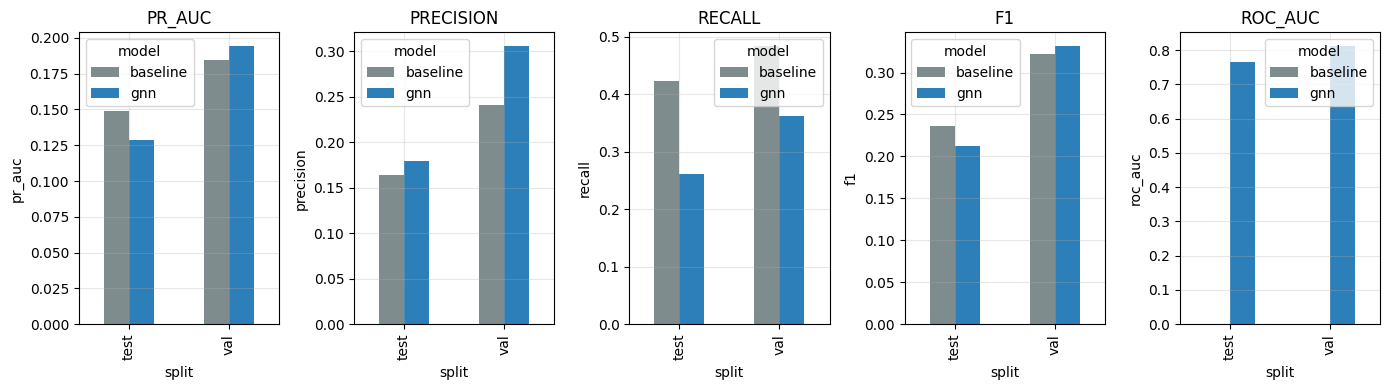

In [9]:
# Ensure compare_models_table is available
try:
    compare_models_table
except NameError:
    from utils_post_processing import compare_models_table

metrics_raw = compare_models_table().copy()
if 'PR_AUC' in metrics_raw.columns:
    metrics_raw['pr_auc'] = metrics_raw.get('pr_auc', metrics_raw['PR_AUC']).fillna(metrics_raw['PR_AUC'])
    metrics_raw.drop(columns=['PR_AUC'], inplace=True, errors='ignore')

keep_cols = ['model', 'split', 'pr_auc', 'precision', 'recall', 'f1', 'roc_auc']
plot_df = metrics_raw[keep_cols].copy()
plot_df = plot_df[plot_df['split'].isin(['val', 'test'])]

if plot_df.empty:
    print('No metrics to plot; run baselines + GNN first.')
else:
    metrics_to_plot = ['pr_auc', 'precision', 'recall', 'f1', 'roc_auc']
    fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(14, 4))
    colors = {'baseline': '#7f8c8d', 'gnn': '#2c7fb8'}
    for ax, m in zip(axes, metrics_to_plot):
        pivot = plot_df.pivot(index='split', columns='model', values=m)
        if set(['baseline','gnn']).issubset(pivot.columns):
            pivot = pivot[['baseline', 'gnn']]
        pivot.plot(kind='bar', ax=ax, color=[colors.get(col, '#555') for col in pivot.columns])
        ax.set_title(m.upper())
        ax.set_xlabel('split'); ax.set_ylabel(m)
        ax.legend(title='model'); ax.grid(alpha=0.3)
    plt.tight_layout(); plt.show()


### Visuals: GNN training curves

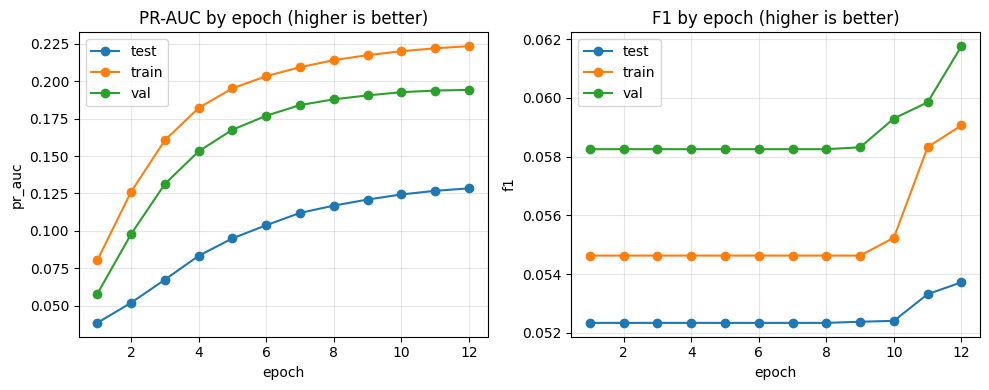

In [10]:
import pandas as pd

try:
    history = gnn_run['history']
except Exception:
    history = None

def plot_gnn_history(history: dict):
    rows = []
    for epoch, rec in history.items():
        for split in ['train', 'val', 'test']:
            if split not in rec:
                continue
            rows.append({
                'epoch': int(epoch),
                'split': split,
                'pr_auc': rec[split].get('pr_auc'),
                'f1': rec[split].get('f1'),
            })
    if not rows:
        print('No per-epoch metrics found; rerun the GNN cell to capture history.')
        return
    hist_df = pd.DataFrame(rows).sort_values(['split', 'epoch'])
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    for split, grp in hist_df.groupby('split'):
        axes[0].plot(grp['epoch'], grp['pr_auc'], marker='o', label=split)
        axes[1].plot(grp['epoch'], grp['f1'], marker='o', label=split)
    axes[0].set_title('PR-AUC by epoch (higher is better)'); axes[0].set_xlabel('epoch'); axes[0].set_ylabel('pr_auc'); axes[0].grid(alpha=0.3)
    axes[1].set_title('F1 by epoch (higher is better)'); axes[1].set_xlabel('epoch'); axes[1].set_ylabel('f1'); axes[1].grid(alpha=0.3)
    for ax in axes:
        ax.legend()
    plt.tight_layout(); plt.show()

if history:
    plot_gnn_history(history)
else:
    print('History not found; rerun the GraphSAGE cell to populate gnn_run.')


### Visuals: validation PR curve + confusion

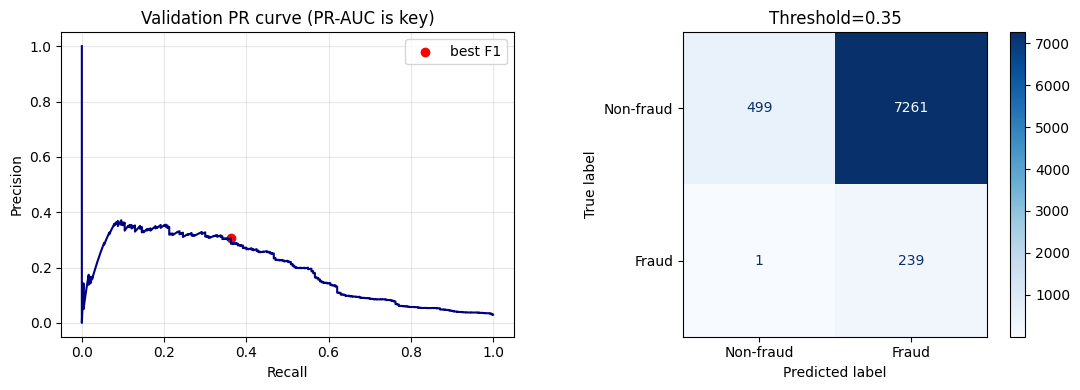

In [11]:
import numpy as np
from sklearn.metrics import precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay

pred_path = Path('data/artifacts/gnn_val_test_preds.parquet')
if not pred_path.exists():
    print('Run train_gnn to produce gnn_val_test_preds.parquet before plotting.')
else:
    preds = load_gnn_error_table()
    val = preds[preds['split'] == 'val']
    if 'isFraud' not in val.columns:
        raise ValueError('Validation predictions missing isFraud labels.')

    probs = val['prob']
    labels = val['isFraud']
    prec, rec, thresh = precision_recall_curve(labels, probs)

    fig, axes = plt.subplots(1, 2, figsize=(11, 4))
    axes[0].plot(rec, prec, color='navy')
    axes[0].set_xlabel('Recall'); axes[0].set_ylabel('Precision'); axes[0].set_title('Validation PR curve (PR-AUC is key)'); axes[0].grid(alpha=0.3)
    f1_scores = (2 * prec * rec) / np.clip(prec + rec, 1e-12, None)
    best_idx = int(np.nanargmax(f1_scores))
    axes[0].scatter(rec[best_idx], prec[best_idx], color='red', label='best F1'); axes[0].legend()

    threshold = THRESHOLD if 'THRESHOLD' in globals() else 0.5
    pred_labels = (probs >= threshold).astype(int)
    cm = confusion_matrix(labels, pred_labels)
    ConfusionMatrixDisplay(cm, display_labels=['Non-fraud', 'Fraud']).plot(ax=axes[1], cmap='Blues', values_format='d')
    axes[1].set_title(f'Threshold={threshold:.2f}')
    plt.tight_layout(); plt.show()


## Precision@k (validation set)

In [12]:
pred_path = Path('data/artifacts/gnn_val_test_preds.parquet')
if not pred_path.exists():
    print('Run the GNN training cell to produce gnn_val_test_preds.parquet')
else:
    preds = load_gnn_error_table()
    val = preds[preds['split'] == 'val']
    if 'isFraud' in val.columns:
        p_at_5, r_at_5 = precision_recall_at_k(val['prob'], val['isFraud'], 0.05)
        print({'precision@5%': p_at_5, 'recall@5%': r_at_5})
    display(val.head())


{'precision@5%': 0.2575, 'recall@5%': 0.42916666666666664}


,split,TransactionID,card1,TransactionDT,isFraud,prob,pred_label,error_type
0,val,3011000,5465,607658,0,0.453182,0,correct
1,val,3011001,18227,607669,0,0.427315,0,correct
2,val,3011002,6252,607689,0,0.394535,0,correct
3,val,3011003,14858,607704,0,0.365006,0,correct
4,val,3011004,11162,607718,1,0.536195,0,FN


## Quick FP/FN examples

In [13]:
pred_path = Path('data/artifacts/gnn_val_test_preds.parquet')
if not pred_path.exists():
    print('Run the GNN training cell to produce gnn_val_test_preds.parquet')
else:
    preds = load_gnn_error_table()
    fp = preds[preds['error_type'] == 'FP'].sort_values('prob', ascending=False).head(5)
    fn = preds[preds['error_type'] == 'FN'].sort_values('prob', ascending=True).head(5)
    display({'false_positives': fp, 'false_negatives': fn})


{'false_positives':      split  TransactionID card1  TransactionDT  isFraud      prob  pred_label  \
 380    val        3011380  4504         613893        0  0.984056           1   
 197    val        3011197  4504         610705        0  0.983982           1   
 3889   val        3014889  4504         696036        0  0.983915           1   
 550    val        3011550  4504         618107        0  0.983778           1   
 4163   val        3015163  4504         701241        0  0.983469           1   
 
      error_type  
 380          FP  
 197          FP  
 3889         FP  
 550          FP  
 4163         FP  ,
 'false_negatives':       split  TransactionID  card1  TransactionDT  isFraud      prob  \
 10239  test        3021239   7919         848744        1  0.278398   
 4080    val        3015080   7919         699663        1  0.285287   
 10831  test        3021831   4663         855367        1  0.334980   
 15143  test        3026143  12469         953389        1  0.345

### Takeaways
- Use the CLI/Makefile for long, reproducible runs on the full dataset.
- Tune `SAMPLE_FRAC`, `EPOCHS`, and `hidden_dim` when you have more time/resources.
- Error tables give concrete fraud/non-fraud patterns to narrate.